# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
import string
sentences = []
word_threshold = 32

from nltk import WordPunctTokenizer
#tk = WordPunctTokenizer(separator = '<br />')

for data in tqdm(dataset['train']):
  temp = []
  for s in data['text'].split('<br /><br />'): # некоторые предложения отделены рызрывом строки, а не точкой
    temp += sent_tokenize(s)
  for s in temp:
    if len(s.split()) < word_threshold:
      sentences += [s.lower().translate(str.maketrans('', '', string.punctuation))]
# Получить отдельные предложения и поместить их в sentences

  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
print("Всего предложений:", len(sentences))

Всего предложений: 276695


In [8]:
print(sentences[20])

this film is interesting as an experiment but tells no cogent story


Посчитаем для каждого слова его встречаемость.

In [9]:
words = Counter()

for sentence in tqdm(sentences):
  for word in word_tokenize(sentence):
    words[word] += 1


# Расчет встречаемости слов

  0%|          | 0/276695 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [10]:
vocab = set()
vocab_size = 40000

vocab = []
for a, _ in words.most_common(vocab_size):
  vocab += [a]
vocab += ['<unk>', '<bos>', '<eos>', '<pad>']


# Наполнение словаря

In [11]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [12]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [13]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [14]:
print(vocab[:10])

['the', 'a', 'and', 'of', 'to', 'is', 'in', 'this', 'it', 'i']


In [15]:
word2ind['<unk>']

40000

In [16]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        # Допишите код здесь
        tokenized_sentence += [self.bos_id]
        tokens = word_tokenize(self.data[idx])
        for token in tokens:
          id = word2ind[token] if token in word2ind else self.unk_id
          tokenized_sentence += [id]
        tokenized_sentence += [self.eos_id]
        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [17]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [18]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [19]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = logits = model(batch['input_ids']).to(device)
            logits = logits.permute(0, 2, 1)
            target = batch['target_ids'].to(device) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, target)
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [20]:
def train_model(model, dataloader, optimizer, criterion, epoch_losses, epoch):
    for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
        optimizer.zero_grad()
        logits = model(batch['input_ids']).to(device)
        logits = logits.permute(0, 2, 1)
        target = batch['target_ids'].to(device)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    # Напишите код здесь

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [21]:
hidden_dim = 256

class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, len(vocab))

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [22]:
model = LanguageModel().to(device)
criterion = nn.CrossEntropyLoss(ignore_index = word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Обучите модель здесь
num_epoch = 10
losses = []
perplexities = []
#models = []
for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    train_model(model, train_dataloader, optimizer, criterion, epoch_losses, epoch)

    loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(loss)
    perplexity = evaluate(model, criterion, eval_dataloader)
    perplexities.append(perplexity)
    #models.append(model)
    #torch.save(model, f'/content/drive/MyDrive/models/model_{epoch}')
    print(f"Perplexity on epoch {epoch}: {perplexity}")

Training epoch 0::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 0: 252.03086689288256


Training epoch 1::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 1: 186.95752548796506


Training epoch 2::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 2: 159.603840089528


Training epoch 3::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 3: 146.87027959267812


Training epoch 4::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 4: 138.93517518021463


Training epoch 5::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 5: 134.5995201583707


Training epoch 6::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 6: 129.06896257003515


Training epoch 7::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 7: 125.35406884432501


Training epoch 8::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 8: 122.4683155973789


Training epoch 9::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 9: 123.62452055501453


In [ ]:
print(perplexities)

[252.03086689288256, 186.95752548796506, 159.603840089528, 146.87027959267812, 138.93517518021463, 134.5995201583707, 129.06896257003515, 125.35406884432501, 122.4683155973789, 123.62452055501453]


In [ ]:
model = torch.load('/content/drive/MyDrive/models/model_4', map_location=torch.device('cpu'))

In [ ]:
result = evaluate(model, criterion, test_dataloader)

In [ ]:
print('Перплексия:', result)

Перплексия: 123.86737501654329


In [ ]:
table_ = {'Epoch': [i + 1 for i in range(10)], 'Perplexity': perplexities}

<function matplotlib.pyplot.show(close=None, block=None)>

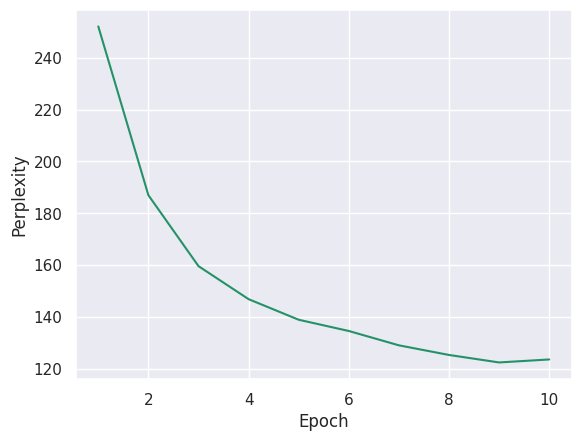

In [ ]:
plt.plot('Epoch', 'Perplexity', data = table_)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.show()

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [24]:
hidden_dim = 256

class NewLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, len(vocab))
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = nn.BatchNorm1d(output.shape[1]).to(device)(output)
        output = self.dropout(nn.BatchNorm1d(output.shape[1]).to(device)(self.linear(self.non_lin(output))))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [25]:
model = NewLanguageModel().to(device)
criterion = nn.CrossEntropyLoss(ignore_index = word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

Training epoch 0::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 0: 192.84692220484956


Training epoch 1::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 1: 150.23419416711687


Training epoch 2::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 2: 130.03666415289527


Training epoch 3::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 3: 117.86870967360363


Training epoch 4::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 4: 109.81995074248336


Training epoch 5::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 5: 103.97039131496264


Training epoch 6::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 6: 98.88647023358905


Training epoch 7::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 7: 95.04304133158497


Training epoch 8::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 8: 91.65144430014075


Training epoch 9::   0%|          | 0/1730 [00:00<?, ?it/s]

Perplexity on epoch 9: 88.74237380261557


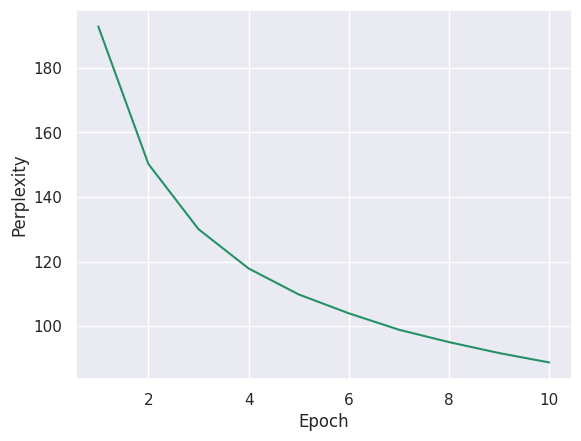

Перплексия: 88.80254841821267


In [26]:
# Обучите модель здесь
num_epoch = 10
losses = []
perplexities = []
#models = []
for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    train_model(model, train_dataloader, optimizer, criterion, epoch_losses, epoch)

    loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(loss)
    perplexity = evaluate(model, criterion, eval_dataloader)
    perplexities.append(perplexity)
    #models.append(model)
    #torch.save(model, f'/content/drive/MyDrive/models/model_{epoch}')
    print(f"Perplexity on epoch {epoch}: {perplexity}")

plt.plot([i + 1 for i in range(10)], perplexities)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.show()

model.eval()
result = evaluate(model, criterion, test_dataloader)
print('Перплексия:', result)

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Первая модель использовала один слой RNN, dropout 0.1, два линейных слоя и нелинейную активацию Tanh между каждый слоем. Перплексия на валидационной выборке стабильно умаеньшалась с эпохами, но по-видимому на последней эпохе модель начала переобучаться. Перплексия на тестовой выборке была близка к 124.

Во второй модели слой RNN был заменен на слой GRU, а также была добавлена нормализация по батчам. Это привело к лучшей перплексии на валидационной выборке, что видно из графика. На тестовой выборке перплексия составила около 89, что значительно лучше предыдущего результата.

Важно отметить, что вторая модель не перестала улучшаться к концу обучения, что говорит о том, что разумно увеличить количество эпох до 15 и понаблюдать за поведением модели. Также для улучшения можно попробовать следующие подходы: добавить еще один слой GRU и увеличить дропаут до 0.3, так как 0.1 кажется слишком низким значением.